In [1]:
import os
import sys

## Using this Notebook
Before running this example, make sure that the **Python module of OpenSn** was installed.

### Converting and Running this Notebook from the Terminal
To run this notebook from the terminal, simply type:

`jupyter nbconvert --to python --execute problem_one.ipynb`.

To run this notebook in parallel (for example, using 4 processes), simply type:

`mpiexec -n 4 jupyter nbconvert --to python --execute problem_1.ipynb`.

In [2]:
from mpi4py import MPI
size = MPI.COMM_WORLD.size
rank = MPI.COMM_WORLD.rank

if rank == 0:
    print(f"Running the first LBS example with {size} MPI processors.")

Running the first LBS example with 1 MPI processors.


## Import Requirements

Import required classes and functions from the Python interface of OpenSn. Make sure that the path
to PyOpenSn is appended to Python's PATH.

In [3]:
# assuming that the execute dir is the notebook dir
# this line is not necessary when PyOpenSn is installed using pip
# sys.path.append("../../../..")

from pyopensn.mesh import OrthogonalMeshGenerator, KBAGraphPartitioner
from pyopensn.xs import MultiGroupXS
from pyopensn.source import VolumetricSource
from pyopensn.aquad import GLCProductQuadrature3DXYZ
from pyopensn.solver import DiscreteOrdinatesProblem, SteadyStateSolver, DiscreteOrdinatesCurvilinearProblem
from pyopensn.diffusion import DFEMDiffusionSolver
from pyopensn.fieldfunc import FieldFunctionInterpolationVolume, FieldFunctionGridBased
from pyopensn.context import UseColor, Finalize
from pyopensn.logvol import SphereLogicalVolume, BooleanLogicalVolume, RPPLogicalVolume
from pyopensn.math import Vector3, ScalarSpatialMaterialFunction
import numpy as np
import math

OpenSn version 0.0.1
2025-05-10 17:07:30 Running OpenSn with 1 processes.



In [4]:
import matplotlib.pyplot as plt

##### Disable colorized output.

In [5]:
UseColor(False)

In [6]:
nodes = []
n_cells = 50
length = 1.0
xmin = 0
dx = length / n_cells
for i in range(n_cells + 1):
    nodes.append(xmin + i * dx)

In [7]:
meshgen = OrthogonalMeshGenerator(
    node_sets=[nodes, nodes, nodes],
    partitioner=KBAGraphPartitioner(
        nx=2,
        ny=2,
        nz=1,
        xcuts=[0.0],
        ycuts=[0.0]
    )
)
grid = meshgen.Execute()

[0]  Done checking cell-center-to-face orientations
[0]  00:00:03.6 Establishing cell connectivity.
[0]  00:00:03.6 Vertex cell subscriptions complete.
[0]  00:00:03.6 Surpassing cell 12500 of 125000 (10%)
[0]  00:00:03.6 Surpassing cell 25000 of 125000 (20%)
[0]  00:00:03.6 Surpassing cell 37501 of 125000 (30%)
[0]  00:00:03.6 Surpassing cell 50000 of 125000 (40%)
[0]  00:00:03.6 Surpassing cell 62500 of 125000 (50%)
[0]  00:00:03.6 Surpassing cell 75001 of 125000 (60%)
[0]  00:00:03.6 Surpassing cell 87501 of 125000 (70%)
[0]  00:00:03.6 Surpassing cell 100000 of 125000 (80%)
[0]  00:00:03.6 Surpassing cell 112500 of 125000 (90%)
[0]  00:00:03.6 Surpassing cell 125000 of 125000 (100%)
[0]  00:00:03.6 Establishing cell boundary connectivity.
[0]  00:00:03.7 Done establishing cell connectivity.
[0]  *** WARNING ***  KBAGraphPartitioner::Partition nx_*ny_*nz_ != number_of_parts
[0]  Number of cells per partition (max,min,avg) = 125000,125000,125000
[0]  
[0]  Mesh statistics:
[0]    Glo

In [8]:
grid.SetUniformBlockID(0)

[0]  00:00:06.0 Done setting block id 0 to all cells


In [9]:
def mat_id_function(pt, cur_id):
    if 0. < ((pt.x ** 2 + pt.y ** 2 + pt.z ** 2) ** (1/2)) < 0.5:
        return 1
    return cur_id

In [10]:
grid.SetBlockIDFromFunction(mat_id_function)

In [11]:
xs_mat = MultiGroupXS()
xs_mat.CreateSimpleOneGroup(sigma_t=1.,c=0.0)
xs_void = MultiGroupXS()
xs_void.CreateSimpleOneGroup(sigma_t=0.,c=0.0)
xs_src = MultiGroupXS()
xs_src.CreateSimpleOneGroup(sigma_t=0.,c=0.0)

[0]  *** WARNING ***  Negative transport cross section found for group 0 in call to ComputeDiffusionParameters. sigma_t=0 sigma_1=0. Setting sigma_1=0, sigma_tr=sigma_t for this group.
[0]  *** WARNING ***  Negative transport cross section found for group 0 in call to ComputeDiffusionParameters. sigma_t=0 sigma_1=0. Setting sigma_1=0, sigma_tr=sigma_t for this group.


In [13]:
mg_src = VolumetricSource(block_ids=[1], group_strength=[1.])

In [14]:
nazimu = 4
npolar = 2
pquad = GLCProductQuadrature3DXYZ(npolar, nazimu)

In [15]:
phys = DiscreteOrdinatesProblem(
    mesh=grid,
    num_groups=1,
    groupsets=[
        {
            "groups_from_to": (0, 0),
            "angular_quadrature": pquad,
            "angle_aggregation_num_subsets": 1,
            "inner_linear_method": "petsc_gmres",
            "l_abs_tol": 1.0e-6,
            "l_max_its": 300,
            "gmres_restart_interval": 30
        }
    ],
    options={
        "scattering_order": 0,
        "volumetric_sources": [mg_src],
        "boundary_conditions": [
            {"name":"xmin", "type":"reflecting"},
            {"name":"xmax", "type":"vacuum"},
            {"name":"ymin", "type":"reflecting"},
            {"name":"ymax", "type":"vacuum"},
            {"name":"zmin", "type":"reflecting"},
            {"name":"zmax", "type":"vacuum"}
        ]
    },
    xs_map=[
        {
            "block_ids": [0],
            "xs": xs_void
        },
        {
            "block_ids": [1],
            "xs": xs_src
        }
    ]
)

In [16]:
ss_solver = SteadyStateSolver(lbs_problem=phys)
ss_solver.Initialize()
ss_solver.Execute()

[0]  
[0]  Initializing LBS SteadyStateSolver with name: LBSDiscreteOrdinatesProblem
[0]  
[0]  Scattering order    : 0
[0]  Number of Groups    : 1
[0]  Number of Group sets: 1
[0]  
[0]  ***** Groupset 0 *****
[0]  Groups:
[0]      0 
[0]  
[0]  Initializing spatial discretization.
[0]  Computing unit integrals.
[0]  Ghost cell unit cell-matrix ratio: 0%
[0]  Cell matrices computed.
[0]  Initializing parallel arrays. G=1 M=1
[0]  Done with parallel arrays.
[0]  Volumetric source #0 has 8219 total subscribing cells.
[0]  00:01:14.3 Initializing sweep datastructures.
[0]  00:01:30.3 Done initializing sweep datastructures.
[0]  00:01:30.3 Initialized angle aggregation.
[0]  Initializing WGS and AGS solvers
[0]  
[0]  
[0]  ********** Solving groupset 0 with PETSC_GMRES.
[0]  
[0]  Quadrature number of angles: 8
[0]  Groups 0 0
[0]  
[0]  Total number of angular unknowns: 8000000
[0]  Number of lagged angular unknowns: 0(0%)
[0]  00:01:30.6 Computing b
[0]  00:01:35.3 WGS groups [0-0] It

In [17]:
fflist = phys.GetFieldFunctions()

[0]  Exporting field functions to VTK with file base "problem_two"
[0]  Done exporting field functions to VTK.


In [18]:
def average_vol(vol0, r1, r2):
    ffvol = FieldFunctionInterpolationVolume()
    ffvol.SetOperationType("avg")
    ffvol.SetLogicalVolume(vol0)
    ffvol.AddFieldFunction(fflist[0])
    ffvol.Initialize()
    ffvol.Execute()
    avgval = ffvol.GetValue()
    print("Radius: {:.2f} {:.2f} {:.6f}".format(r1, r2, avgval))
    return avgval

def create_vols(N_vols, rmax):
    r_vals = np.linspace(0, rmax, N_vols + 1)
    vols = np.empty(N_vols)
    avgphi = np.zeros(N_vols)
    for i in range(N_vols):
        if i != 0:
            inner_vol = SphereLogicalVolume(r=r_vals[i])
            outer_vol = SphereLogicalVolume(r=r_vals[i + 1])
            vol = BooleanLogicalVolume(parts=[{"op":True,"lv":outer_vol},{"op":False,"lv":inner_vol}])
        else:
            vol = SphereLogicalVolume(r=r_vals[i + 1])
        avgphi[i] = average_vol(vol, r_vals[i], r_vals[i+1])
    return avgphi

In [19]:
n_vols = 10
sim_vals = create_vols(n_vols, 1)

Radius: 0.00 0.10 0.495648
Radius: 0.10 0.20 0.482259
Radius: 0.20 0.30 0.452957
Radius: 0.30 0.40 0.404214
Radius: 0.40 0.50 0.319084
Radius: 0.50 0.60 0.180303
Radius: 0.60 0.70 0.115349
Radius: 0.70 0.80 0.082708
Radius: 0.80 0.90 0.062657
Radius: 0.90 1.00 0.049197


In [20]:
def get_phi(r, q, a):
    phi = q*(a+(a**2-r**2)/(2*r)*math.log((a+r)/(abs(r-a))))
    return phi        

In [21]:
q = 0.5
a = 0.5
r_vals = np.linspace(0.05, 0.95, n_vols)
phi = np.zeros(n_vols)
for i in range(n_vols):
    phi[i] = get_phi(r_vals[i], q, a)
    print(r_vals[i], phi[i])

0.05 0.4983299856344121
0.15 0.4847190331873598
0.25 0.45598980412527057
0.35 0.4079725961157026
0.44999999999999996 0.32770047306133665
0.5499999999999999 0.17734662364523654
0.65 0.11486071828748867
0.75 0.08235021745478122
0.85 0.0623998900710559
0.95 0.049086449380449704


In [23]:
err = np.zeros(n_vols)
err[:] = 100*abs(phi[:]-sim_vals[:])/phi[:]
print(err)

[0.53821642 0.50750074 0.66500382 0.92118179 2.62925088 1.66698857
 0.42503756 0.43503893 0.41219669 0.22472521]


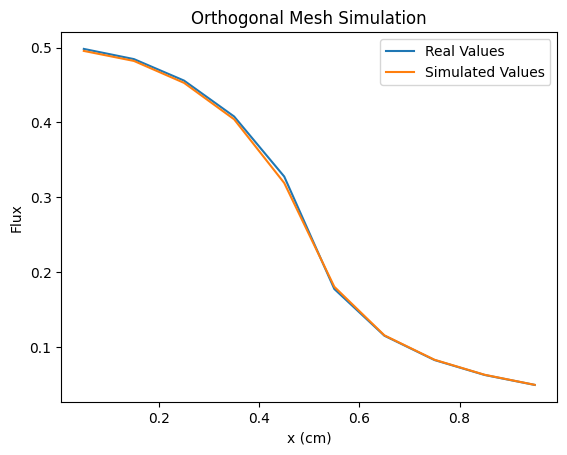

In [22]:
plt.figure(1)
plt.plot(r_vals,phi)
plt.plot(r_vals,sim_vals)
plt.title("Orthogonal Mesh Simulation")
plt.xlabel("x (cm)")
plt.ylabel("Flux") 
plt.legend(["Real Values", "Simulated Values"])
plt.show()

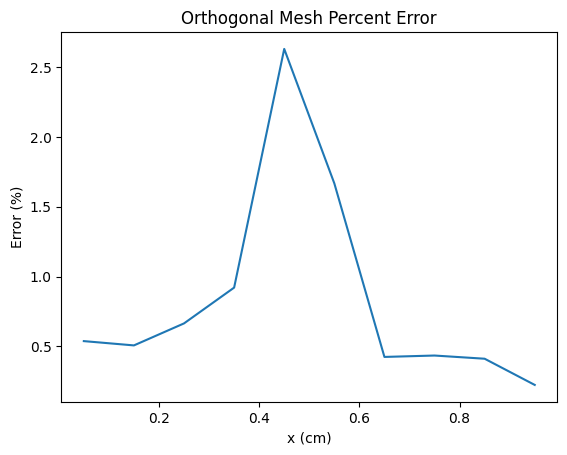

In [24]:
plt.figure(2)
plt.plot(r_vals,err)
plt.title("Orthogonal Mesh Percent Error")
plt.ylabel("Error (%)")
plt.xlabel("x (cm)")
plt.show()

## Finalize (for Jupyter Notebook only)

In Python script mode, PyOpenSn automatically handles environment termination. However, this
automatic finalization does not occur when running in a Jupyter notebook, so explicit finalization
of the environment at the end of the notebook is required. Do not call the finalization in Python
script mode, or in console mode.

Note that PyOpenSn's finalization must be called before MPI's finalization.


In [23]:
from IPython import get_ipython

def finalize_env():
    Finalize()
    MPI.Finalize()

ipython_instance = get_ipython()
if ipython_instance is not None:
    ipython_instance.events.register("post_execute", finalize_env)


Elapsed execution time: 00:09:39.5
2025-05-09 14:11:49 OpenSn finished execution.
